<a href="https://colab.research.google.com/github/AshleyBrooks213/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/Unit2Sprint2Assignment4_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#I. Wrangle Data

*    How can we transform our target so that it is a **binary classification** problem?

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv',
                             na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv',
                   na_values=[0, -2.000000e-08],
                   index_col='id')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [4]:
print(train.shape, test.shape)

(59399, 40) (14358, 39)


New Wrangle Function that drops high cardinality categorical columns, drops repeated columns, and creates a new binary target.

In [5]:
def wrangle(X):
  #Make a copy
  X = X.copy()

  #Drop high cardinality categorical columns
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]
  X.drop(columns=high_card_cols, inplace=True)

  #Drop repeated columns
  col = ['extraction_type_group', 'quantity']
  X.drop(columns=col, inplace=True)

  #Create a new, binary target
  if 'status_group' in X.columns:
    X['needs_repair']=(X['status_group'] != 'functional').astype(int)
    X.drop(columns='status_group', inplace=True)


  return X

In [6]:
train=wrangle(train)
test=wrangle(test)

#II. Split Data

*    Split Target Vector from Feature Matrix

In [7]:
target = 'needs_repair'
y=train[target]

X=train.drop(columns=target)

*    Train-Val Split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#Sanity Check
assert len(X_train) + len(X_val) == len(X)

#IV. Build Model
*    OrdinalEncoder
*    SimpleImputer
*    RandomForestClassifier

In [10]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=75,
                           max_depth=35,
                           max_samples=0.5,
                           random_state=42,
                           n_jobs=-1)  
)

In [11]:
model.fit(X_train, y_train);

In [12]:
model2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=75,
                           max_depth=35,
                           max_samples=0.5,
                           random_state=42,
                           n_jobs=-1)
)  


In [13]:
#Training the same model on ALL of the train dataset instead of splitting it into train and val sets
model2.fit(X, y);

In [14]:
model3 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=66,
                           max_depth=50,
                           max_samples=0.5,
                           random_state=42,
                           n_jobs=-1)  
)

In [15]:
model3.fit(X_train, y_train);

#V. Check Metrics

*    Accuracy

In [16]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9604368778804268
Validation Accuracy: 0.8228114478114478


In [17]:
print('Training Accuracy for model3:', model3.score(X_train, y_train))
print('Validation Accuracy for model3:', model3.score(X_val, y_val))

Training Accuracy for model3: 0.9597845072497316
Validation Accuracy for model3: 0.8232323232323232


*    Confusion Matrix

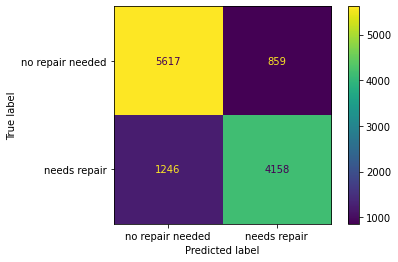

In [18]:
plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      values_format='.0f',
                      display_labels=['no repair needed', 'needs repair']);

*    **Recall**: Of those pumps that actually need repair, what proportion did you correctly predict as needing repair?

*    Can do by hand: TP/TP+FN

In [19]:
print('Recall:', 4130/(4130+1274))

Recall: 0.7642487046632125


*    **Precision**: Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

*    Can do by hand: TP/TP+FP

In [20]:
print('Precision:', 4130/(4130+811))

Precision: 0.8358631855899615


*    **Classifcation Report**

In [21]:
print(classification_report(y_val, model.predict(X_val),
                            target_names=['no repair needed', 'needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.82      0.87      0.84      6476
    needs repair       0.83      0.77      0.80      5404

        accuracy                           0.82     11880
       macro avg       0.82      0.82      0.82     11880
    weighted avg       0.82      0.82      0.82     11880



In [22]:
model.predict(X_val)[:10]

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0])

In [23]:
model.predict_proba(X_val)[:10, -1]

array([1.        , 0.22666667, 0.01333333, 0.41333333, 0.01333333,
       0.84      , 0.        , 0.72272396, 0.94666667, 0.04      ])

#Create Kaggle Submission

*    **1st Model Submission**

In [24]:
y_pred = model.predict(test)
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [25]:
test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,NaN,1996.0,35.290799,-4.059696,NaN,Internal,Manyara,21,3.0,321.0,True,GeoData Consultants Ltd,Parastatal,True,2012.0,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,NaN,1569.0,36.656709,-3.309214,NaN,Pangani,Arusha,2,2.0,300.0,True,GeoData Consultants Ltd,VWC,True,2000.0,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,NaN,1567.0,34.767863,-5.004344,NaN,Internal,Singida,13,2.0,500.0,True,GeoData Consultants Ltd,VWC,NaN,2010.0,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,NaN,267.0,38.058046,-9.418672,NaN,Ruvuma / Southern Coast,Lindi,80,43.0,250.0,NaN,GeoData Consultants Ltd,VWC,True,1987.0,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,1260.0,35.006123,-10.950412,NaN,Ruvuma / Southern Coast,Ruvuma,10,3.0,60.0,NaN,GeoData Consultants Ltd,Water Board,True,2000.0,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [26]:
submission=test[[]]
submission['status_group']=y_pred
submission.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,status_group
id,
50785,1
51630,0
17168,0
45559,1
49871,0


In [27]:
submission.to_csv('1_submission.csv')

*    **2nd Model Submission**

In [28]:
y_pred2 = model2.predict(test)

In [29]:
submission2=test[[]]
submission2['status_group']=y_pred
submission2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,status_group
id,
50785,1
51630,0
17168,0
45559,1
49871,0


In [30]:
submission2.to_csv('2_submission.csv')

*    **3rd Submission**

In [31]:
y_pred = model3.predict(test)
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [32]:
submission = test[[]]
submission['status_group']=y_pred
submission.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,status_group
id,
50785,1
51630,0
17168,0
45559,1
49871,0


In [33]:
submission.to_csv('3_submission.csv')

#**Stacking**

In [35]:
# Filenames of your submissions you want to ensemble
files = ['1_submission.csv', '2_submission.csv', '3_submission.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]
 
#sample_submission = pd.read_csv(sample_submission)
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission2.csv', index=False)